<a href="https://colab.research.google.com/github/componavt/sns4human/blob/main/src/vk/topics/scikit_LDA_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# topics are indicated by an expert for each social network post
filename = '512_posts_24_topics.csv'

# the number of topics the Latent Dirichlet Allocation (LDA) model must extract from the set of documents
n_components = 23 # without unknown topic

# объём тестовой выборки, test_size=0.2 (20% test, 80% evaluation)
test_size=0.3
# test_size=0.01 # почти все посты идут на обучение LDA и рисование графа

# using threshold per predicted topic (in Graph Step 3: adding edges)
threshold = 0.17
#threshold = 0.23
#threshold = 0.30
# threshold = 0.38 0.35


In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
!pip install -U pymorphy3
import pymorphy3
import requests
import csv
import gzip
import shutil

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

from nltk.corpus import stopwords
stop_words = stopwords.words("russian")

#stop_words += requests.get('https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/src/vk/nlp/RussianStopWords.txt').text.split('\n')
#stop_words += requests.get('https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/src/vk/nlp/stopwords-ru.txt').text.split()
alphabet = set('абвгдеёжзийклмнопрстуфхцчшщъыьэюя')
alphabet_dash = alphabet | {'-'}# alphabet + dash

morph = pymorphy3.MorphAnalyzer(lang='ru')

from io import StringIO
response = requests.get(f'https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/data/vk/topics/{filename}')
df = pd.read_csv(StringIO(response.text), delimiter=',', encoding='utf-8')

# Remove unassigned topic posts
df = df[df['topic'].str.lower() != 'пусто'].copy()

print(f"Total posts after filtering: {len(df)}")

Total posts after filtering: 463
None


In [ ]:
def get_text_window(words, index, window_size=3):
    """Returns a context window of words around the given index."""
    start = max(0, index - window_size)
    end = min(len(words), index + window_size + 1)
    return ' '.join(words[start:end])

def contains_non_dash(s):
    """Check if a string consists not only dash characters."""
    return s.count('-') < len(s)

def process_text(text):
    sentences = sent_tokenize(text)  # Split into sentences
    processed_sentences = []

    for sentence in sentences:
        check_hash = False
        processed_parts = []
        words = word_tokenize(sentence)

        for i, w in enumerate(words):
          if len(w) == 1:
            continue
          if w == '#':
            check_hash = True
            continue
          if check_hash:
            check_hash = False
            continue

          # skip name and surname
          # w_tag = morph.parse(w.strip())[0].tag
          #if 'Surn' in w_tag or 'Name' in w_tag or 'Patr' in w_tag:
          #  context = get_text_window(words, i)
          #  print(f"Filtered name/surname: {w} | Context: {context}")  # Debug output for context
          #  continue

          if set(w.lower()).issubset(alphabet_dash) and contains_non_dash(w):
            res = morph.parse(w.lower())[0].normal_form
            if res and (res not in stop_words):
                  processed_parts.append(res)
          else:
            # has 4+ Cyrillic characters then will parse too (e.g. блж.Фаддея о.Алексия г.Петрозаводске)
            if sum(1 for char in w.lower() if char in alphabet) >= 4:
              if ('\\' not in w) and ('/' not in w): # skip words-hyperlinks
                #context = get_text_window(words, i)
                #print(f"Filtered not subset(alphabet): {w} | Context: {context}")
                res = morph.parse(w.lower())[0].normal_form
                if res not in stop_words:
                  processed_parts.append(res)

        if processed_parts:
            last_word = processed_parts[-1]
            if last_word[-1] not in ".!?":
                #processed_parts.append(".")  # Add period at the end of sentence
                processed_parts[-1] += "."    # Attach period directly to the last word

        processed_sentences.append(" ".join(processed_parts))

    return " ".join(processed_sentences).strip()

In [ ]:
!pip install pymorphy3
import pymorphy3
morph = pymorphy3.MorphAnalyzer(lang='ru')

for index, row in df.iterrows():
    text = row['text'].lower()
    df.loc[index, 'normalized'] = process_text(row['text'])  # .lower())

In [ ]:
from sklearn.model_selection import train_test_split
train_docs, test_docs = train_test_split(df, test_size=test_size, random_state=42, shuffle=True)

unique_topics = sorted(train_docs['topic'].unique())  # sort topics by name
print(f"Total topics: {len(unique_topics)}")
#for i, topic in enumerate(unique_topics, 1):  # print from 1
#    print(f"{i}. {topic}")

Total topics: 24


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create TF-IDF matrix
#vectorizer = TfidfVectorizer(max_df=.2, min_df=3, max_features=2000)
# TODO: CountVectorizer лучше?
vectorizer = CountVectorizer(
#vectorizer = TfidfVectorizer(
    max_df=0.8,        # Игнорировать слишком частые слова (в >80% документов)
    min_df=2,          # Игнорировать слова, встречающиеся только один раз
    max_features=1000, # Умеренное количество признаков
#    stop_words=stop_words,  # уже убрали
)

# Transform text into TF-IDF matrix
doc_train_matrix = vectorizer.fit_transform(train_docs['normalized'])
doc_test_matrix = vectorizer.transform(test_docs['normalized'])

# Get feature names
words = vectorizer.get_feature_names_out()

# Generate topic labels
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components + 1)]

# Fit LDA model
lda = LatentDirichletAllocation(
    n_components=n_components,
    n_jobs=-1,
    max_iter=77,
    learning_method='batch',
    evaluate_every=10,
    verbose=1,
    random_state=42
)
lda.fit(doc_train_matrix)


# Save and load the model
joblib.dump(lda, 'model.pkl')
lda = joblib.load('model.pkl')

# Compute topic-word probabilities
topics_count = lda.components_
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T, index=words, columns=topic_labels)

# почему первый столбец - это названия группы в ВК (domain)?
topics.head()

iteration: 1 of max_iter: 77
iteration: 2 of max_iter: 77
iteration: 3 of max_iter: 77
iteration: 4 of max_iter: 77
iteration: 5 of max_iter: 77
iteration: 6 of max_iter: 77
iteration: 7 of max_iter: 77
iteration: 8 of max_iter: 77
iteration: 9 of max_iter: 77
iteration: 10 of max_iter: 77, perplexity: 803.8038
iteration: 11 of max_iter: 77
iteration: 12 of max_iter: 77
iteration: 13 of max_iter: 77
iteration: 14 of max_iter: 77
iteration: 15 of max_iter: 77
iteration: 16 of max_iter: 77
iteration: 17 of max_iter: 77
iteration: 18 of max_iter: 77
iteration: 19 of max_iter: 77
iteration: 20 of max_iter: 77, perplexity: 780.9481
iteration: 21 of max_iter: 77
iteration: 22 of max_iter: 77
iteration: 23 of max_iter: 77
iteration: 24 of max_iter: 77
iteration: 25 of max_iter: 77
iteration: 26 of max_iter: 77
iteration: 27 of max_iter: 77
iteration: 28 of max_iter: 77
iteration: 29 of max_iter: 77
iteration: 30 of max_iter: 77, perplexity: 777.3243
iteration: 31 of max_iter: 77
iteration: 32

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24
100,0.000089,0.000233,0.000049,0.000056,0.002193,0.000054,0.000210,0.003108,0.000042,0.001668,...,0.00003,0.000095,0.00004,0.000097,0.000055,0.000125,0.00007,0.000114,0.000080,0.00006
100словокарелия,0.000089,0.000233,0.000049,0.000056,0.000045,0.000054,0.000210,0.000063,0.000042,0.000034,...,0.00003,0.000095,0.00004,0.000097,0.000055,0.003684,0.00007,0.000114,0.000080,0.00006
club147415188,0.000089,0.000233,0.001229,0.003466,0.000045,0.000054,0.000210,0.000063,0.000042,0.000034,...,0.00107,0.000095,0.00004,0.000097,0.001368,0.000125,0.00007,0.000114,0.000080,0.00006
club791498,0.000089,0.000233,0.001229,0.000056,0.002193,0.002626,0.010311,0.000063,0.000042,0.000034,...,0.00003,0.000095,0.00004,0.000097,0.000055,0.000125,0.00007,0.000114,0.001998,0.00006
cамый,0.000089,0.000233,0.000049,0.000056,0.000045,0.000054,0.000210,0.000063,0.000042,0.000034,...,0.00003,0.000095,0.00004,0.000097,0.000055,0.000125,0.00007,0.000114,0.000080,0.00006


In [ ]:
# Extract top words per topic
n_words = 12
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(n_words).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24
0,карелия,ребёнок,карелия,карельский,карелия,выставка,музей,год,карельский,карелия,...,карелия,соус,карелия,калевала,карелия,водопад,тверской,река,музей,карел
1,конкурс,наш,конкурс,карелия,год,музей,национальный,день,язык,республика,...,республика,конкурс,культура,карелия,это,карелия,карелия,жемчуг,художник,это
2,самый,карелия,традиционный,проект,национальный,карельский,карелия,наш,финский,год,...,язык,кухня,это,руно,дом,который,новый,вода,работа,весь
3,который,музей,фонд,который,республика,карелия,давать,народный,людиковский,народный,...,карельский,жюри,свой,руна,который,песня,область,время,вопрос,всё
4,книга,сказка,пройти,ансамбль,музей,год,свой,новый,карелия,конкурс,...,конкурс,сво,карельский,карельский,день,вода,наш,весь,который,человек
5,победитель,школьник,работа,республика,рубль,петрозаводск,самовар,ноябрь,вепсский,хор,...,народ,семья,работа,эпос,вопрос,свой,год,наш,родственник,карелия
6,олень,внимание,александр,поддержка,билет,история,здоровье,музыкальный,русский,карельский,...,год,повар,год,культура,год,это,семья,всё,карелия,акция
7,вепс,родитель,калевала,народный,район,национальныймузейкарелия,национальныймузейкарелия,весь,год,район,...,вепсский,участник,наш,карельскиесказитель,мочь,карельский,это,карелия,карельский,карельский
8,новый,герой,олонец,день,состояться,центр,наш,россия,наречие,программа,...,семинар,место,народный,годкарельскихрун,печь,хозяйка,весь,это,тема,россия
9,год,стоимость,год,море,наш,новый,весь,москва,сказка,коллектив,...,история,наш,который,дом,республика,слово,свой,друг,россия,мочь


# Скрипт lda_model_selection:
1.   Перебирает значения n_components от 5 до 30.
2.   Для каждого обучает LDA, сопоставляет темы с экспертными через linear_sum_assignment.
3.   Считает accuracy и macro F1-score по обучающей выборке.
4.   Строит график зависимости метрик от количества тем.

Training LDA with 5 topics...
Accuracy: 0.207, Macro F1: 0.071
Training LDA with 6 topics...
Accuracy: 0.176, Macro F1: 0.072
Training LDA with 7 topics...
Accuracy: 0.176, Macro F1: 0.079
Training LDA with 8 topics...
Accuracy: 0.190, Macro F1: 0.094
Training LDA with 9 topics...
Accuracy: 0.182, Macro F1: 0.100
Training LDA with 10 topics...
Accuracy: 0.198, Macro F1: 0.109
Training LDA with 11 topics...
Accuracy: 0.182, Macro F1: 0.111
Training LDA with 12 topics...
Accuracy: 0.179, Macro F1: 0.114
Training LDA with 13 topics...
Accuracy: 0.179, Macro F1: 0.129
Training LDA with 14 topics...
Accuracy: 0.173, Macro F1: 0.125
Training LDA with 15 topics...
Accuracy: 0.179, Macro F1: 0.134
Training LDA with 16 topics...
Accuracy: 0.196, Macro F1: 0.148
Training LDA with 17 topics...
Accuracy: 0.176, Macro F1: 0.142
Training LDA with 18 topics...
Accuracy: 0.182, Macro F1: 0.153
Training LDA with 19 topics...
Accuracy: 0.212, Macro F1: 0.186
Training LDA with 20 topics...
Accuracy: 0.21

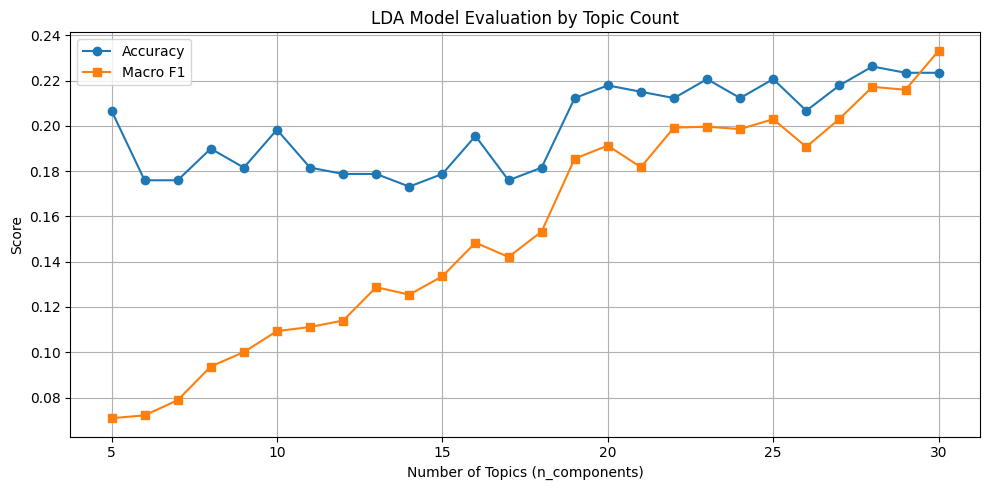

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Range of topic numbers to test
component_range = range(5, 31)
accuracy_scores = []
macro_f1_scores = []

for n_topics in component_range:
    print(f"Training LDA with {n_topics} topics...")
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        n_jobs=-1,
        max_iter=77,
        learning_method='batch',
        evaluate_every=10,
        verbose=0,
        random_state=42
    )
    lda.fit(doc_train_matrix)

    # Predictions
    y_pred = lda.transform(doc_train_matrix).argmax(axis=1)
    y_true = train_docs['topic'].values

    # Matching predicted topics to true labels using Hungarian algorithm
    conf_mat = pd.crosstab(y_true, y_pred, normalize='index')
    row_ind, col_ind = linear_sum_assignment(-conf_mat.values)
    mapping = {col: conf_mat.index[row] for row, col in zip(row_ind, col_ind)}
    y_pred_mapped = [mapping.get(p, 'UNKNOWN') for p in y_pred]

    # Evaluation
    acc = accuracy_score(y_true, y_pred_mapped)
    f1 = f1_score(y_true, y_pred_mapped, average='macro', zero_division=0)
    accuracy_scores.append(acc)
    macro_f1_scores.append(f1)
    print(f"Accuracy: {acc:.3f}, Macro F1: {f1:.3f}")

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(component_range, accuracy_scores, label='Accuracy', marker='o')
plt.plot(component_range, macro_f1_scores, label='Macro F1', marker='s')
plt.xlabel('Number of Topics (n_components)')
plt.ylabel('Score')
plt.title('LDA Model Evaluation by Topic Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Classification Report Lda
1.   Использует linear_sum_assignment для перекодировки predicted topics в соответствующие true topics.
2.   Создаёт classification_report на основе этой перекодировки.
3.   Отображает метрики precision, recall, f1-score по каждой теме.

In [ ]:
# Step: Align predicted topics to true topics using Hungarian algorithm
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import classification_report

# Predicted topic indexes for training data
y_true_train = train_docs['topic'].values
predicted_train = lda.transform(doc_train_matrix).argmax(axis=1)

# Map predicted topic numbers to best matching true topic label
conf_mat = pd.crosstab(y_true_train, predicted_train, normalize='index')
row_ind, col_ind = linear_sum_assignment(-conf_mat.values)

# Mapping of predicted topic index to aligned true topic label
pred_to_true_map = {col: conf_mat.index[row] for row, col in zip(row_ind, col_ind)}

# Apply mapping to predictions for train set
y_pred_train_mapped = [pred_to_true_map.get(pred, 'UNKNOWN') for pred in predicted_train]

# Classification report for train set
print("Classification Report for Training Data (LDA Topics Mapped to True Topics):")
print(classification_report(y_true_train, y_pred_train_mapped, zero_division=0))

# ----------------------------
# Evaluation on test set
# ----------------------------
y_true_test = test_docs['topic'].values
predicted_test = lda.transform(doc_test_matrix).argmax(axis=1)

# Apply same mapping to test predictions
y_pred_test_mapped = [pred_to_true_map.get(pred, 'UNKNOWN') for pred in predicted_test]

# Classification report for test set
print("\nClassification Report for Test Data (LDA Topics Mapped to True Topics):")
print(classification_report(y_true_test, y_pred_test_mapped, zero_division=0))

Classification Report for Training Data (LDA Topics Mapped to True Topics):
                        precision    recall  f1-score   support

         Эпос_Калевала       0.14      0.40      0.21         5
       благоустройство       0.09      0.29      0.14         7
                 вепсы       0.08      0.10      0.09        10
                 война       0.18      0.25      0.21         8
              выставка       0.50      0.59      0.54        17
день рождения и юбилей       0.20      0.14      0.17        14
             еда кухня       0.11      0.23      0.15        13
       карельский язык       0.10      0.07      0.08        14
               конкурс       0.25      0.25      0.25        16
            литература       0.11      0.08      0.10        12
   мероприятия проекты       0.50      0.07      0.12        29
      музей. экскурсия       0.20      0.17      0.18        18
                музыка       0.20      0.45      0.28        11
           образование     

In [ ]:
# Predict topic distribution for training data
train_preds = lda.transform(doc_train_matrix)
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)

# Prepare topic assignment per document
df = train_eval.groupby(level='topic').idxmax(axis=1).reset_index(drop=True)
#topic_pred = train_eval.idxmax(axis=1) # Get the topic with the highest probability for each document
#df = topic_pred.groupby(train_eval.index).value_counts(normalize=True).unstack(fill_value=0) # Group by true topic and count predictions


<ipython-input-23-b115e5e76e15>:6: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  df = train_eval.groupby(level='topic').idxmax(axis=1).reset_index(drop=True)


Text(0.5, 1.0, 'Training: Topic Distribution')

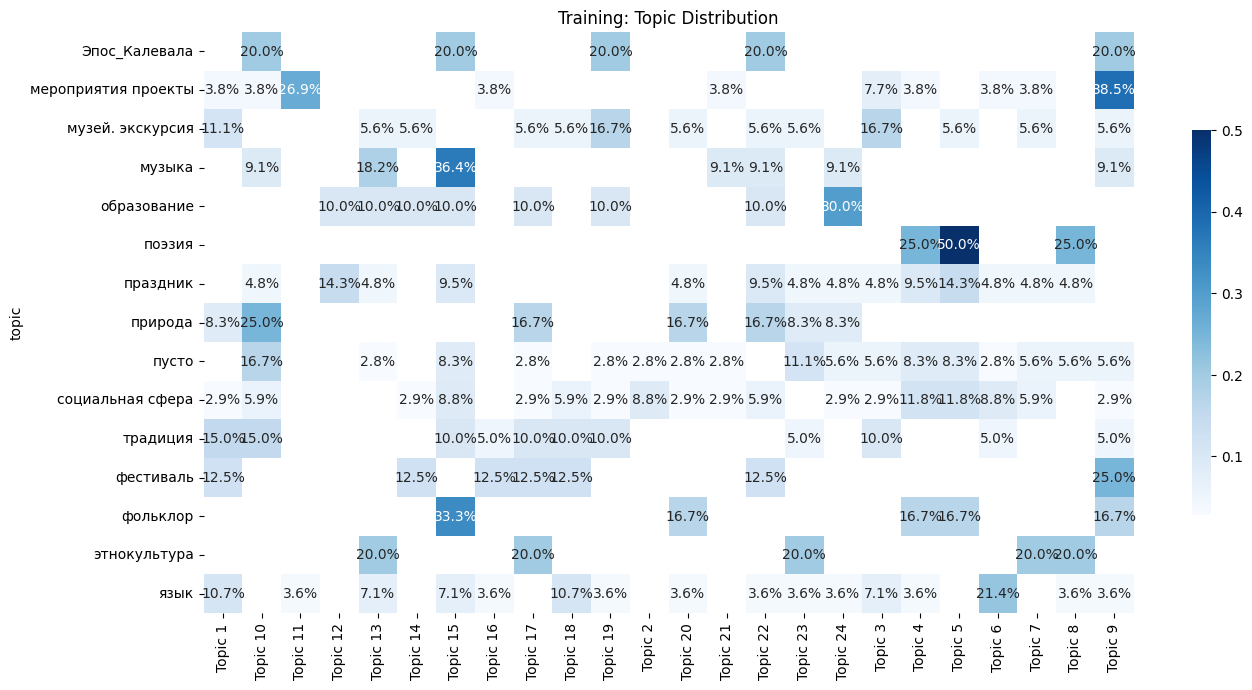

In [ ]:
# Plot heatmap of topic distribution
plt.figure(figsize=(15, 10))
sns.heatmap(
    df.groupby(train_docs.topic).value_counts(normalize=True).unstack(-1),
    annot=True,
    fmt='.1%',
    cmap='Blues',
    square=True,
    cbar_kws={"shrink": 0.5}
)
plt.title('Training: Topic Distribution')
#plt.title('Обучение: Тематики')

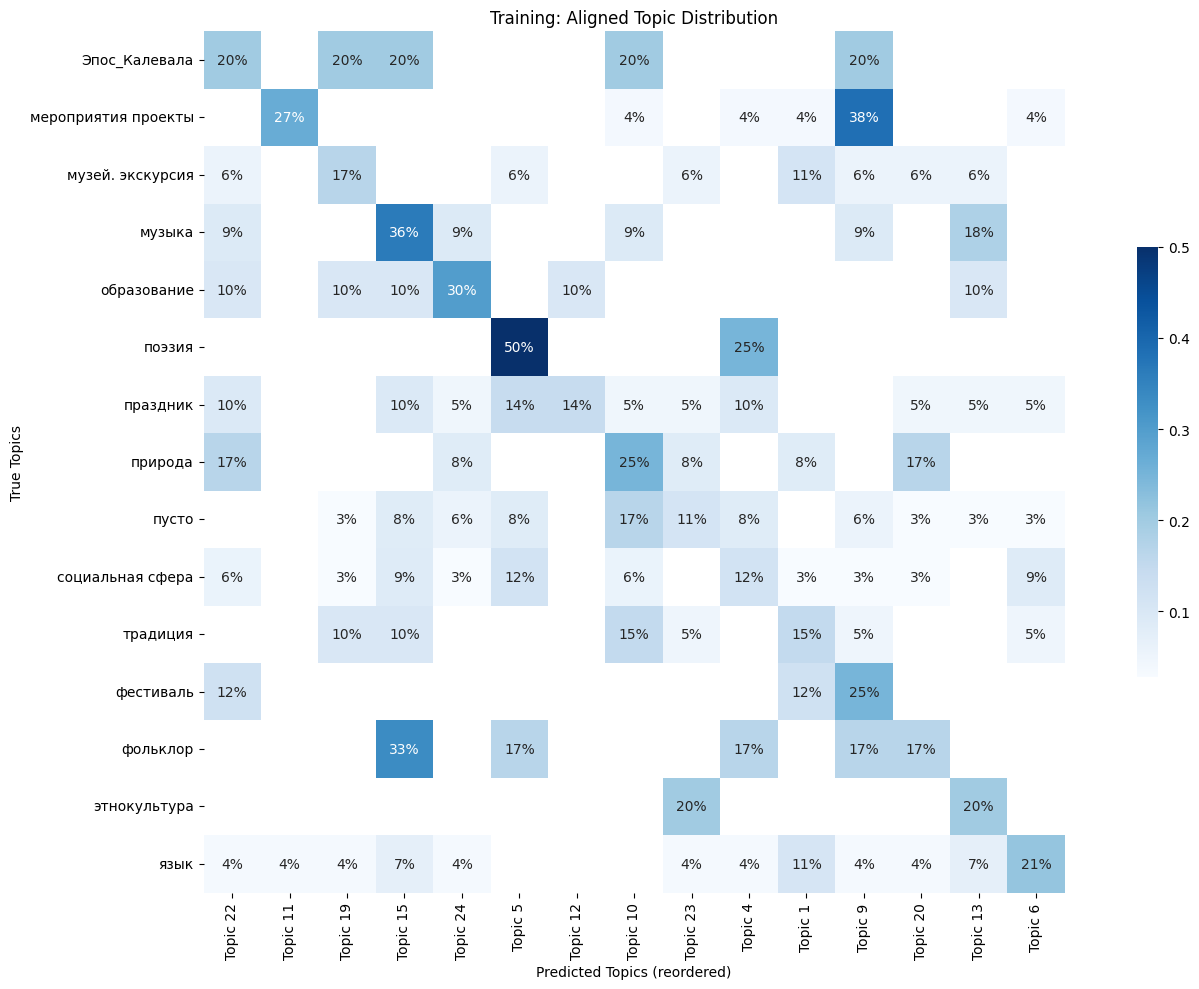

In [ ]:
# Reorder topics for maximum alignment with true topics
confusion_matrix = df.groupby(train_docs.topic).value_counts(normalize=True).unstack(-1)

# Fill possible NaN values with zeros and convert to float
confusion_matrix = confusion_matrix.fillna(0).astype(float)

# Find the optimal assignment
from scipy.optimize import linear_sum_assignment
import numpy as np

try:
    row_ind, col_ind = linear_sum_assignment(-confusion_matrix.values)
    ordered_topics = confusion_matrix.columns[col_ind[np.argsort(row_ind)]]

    # Create a mask for zero values
    mask = confusion_matrix.loc[confusion_matrix.index, ordered_topics] == 0

    plt.figure(figsize=(15, 10))
    sns.heatmap(
        confusion_matrix.loc[confusion_matrix.index, ordered_topics],
        annot=True,
        fmt='.0%',         # Display as '0%' (no decimal)
        cmap='Blues',
        square=True,
        mask=mask,         # Mask cells with zero value
        cbar_kws={"shrink": 0.5}
    )
    plt.title('Training: Aligned Topic Distribution')
    plt.ylabel('True Topics')
    plt.xlabel('Predicted Topics (reordered)')
    plt.tight_layout()

except ValueError as e:
    print(f"Error while processing the matrix: {e}")
    print("Matrix for verification:")
    print(confusion_matrix)
    print("Data types in the matrix:")
    print(confusion_matrix.dtypes)

True topics("карельский язык", "конкурс" и "традиция") тесно связаны между собой через Predicted topics (topic 1, >=17%).
True topics("карельский язык", "литература", "поэзия", "фестиваль" и "этнокультура") тесно связаны между собой через Predicted topics (topic 21, >=17%).
Задача визуализировать вершины графа (True topics), связать их между собой рёбрами, где вес ребра берётся из тех же данных, что и для рисования здесь тепловой карты.


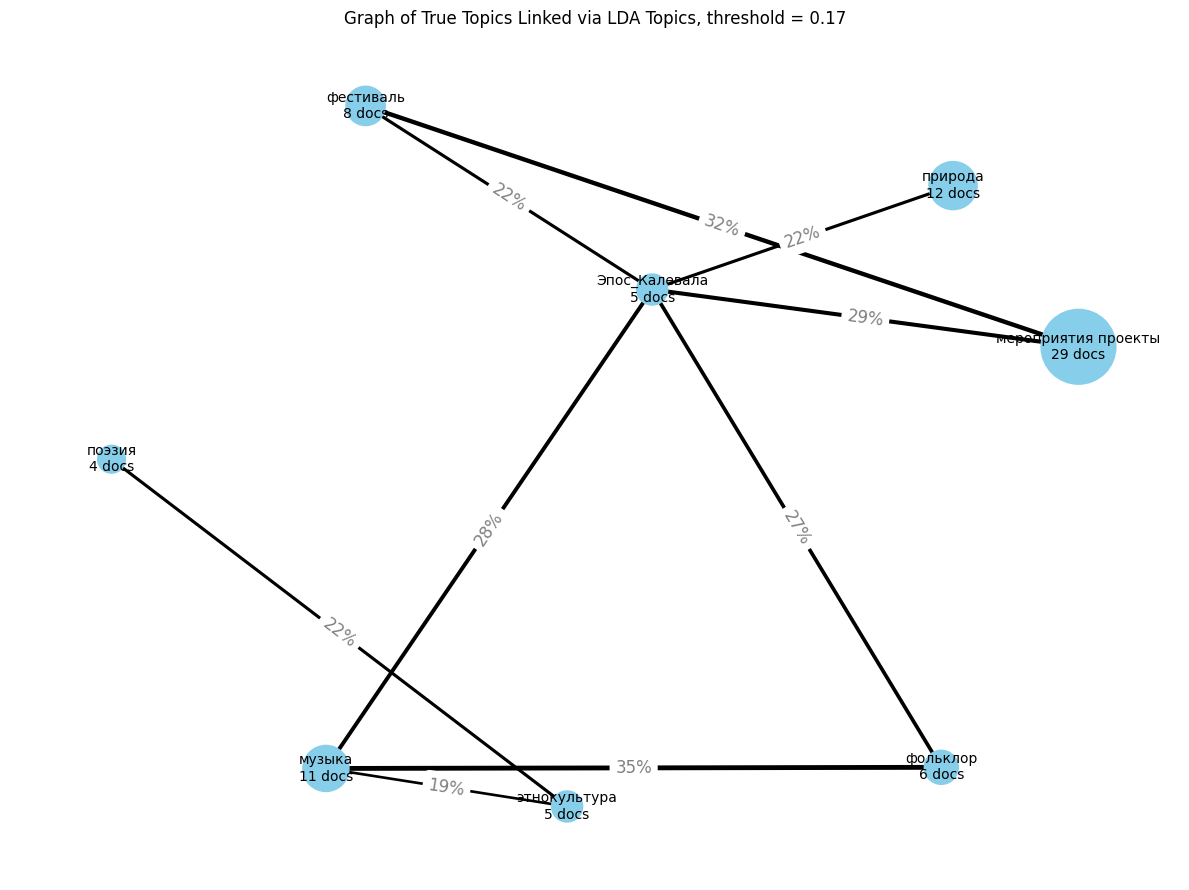

In [ ]:
# Graph visualization of true topic relationships via shared LDA topics
import networkx as nx
import matplotlib.pyplot as plt

# Flag to control whether to keep only connected components or full graph
keep_only_connected = True

# Step 1: build the graph
G = nx.Graph()

# Step 2: add nodes with sizes (document count per topic)
doc_counts = train_docs['topic'].value_counts().to_dict()
for topic in confusion_matrix.index:
    G.add_node(topic, size=doc_counts.get(topic, 1))

# Step 3: add edges using threshold per predicted topic
# threshold = 0.23
for col in confusion_matrix.columns:
    related = confusion_matrix[confusion_matrix[col] >= threshold].index.tolist()
    for i in range(len(related)):
        for j in range(i + 1, len(related)):
            u, v = related[i], related[j]
            weight = (confusion_matrix.loc[u, col] + confusion_matrix.loc[v, col]) / 2
            if G.has_edge(u, v):
                G[u][v]['weight'] += weight
            else:
                G.add_edge(u, v, weight=weight)

# Step 4: choose graph to visualize
if keep_only_connected:
    components = [c for c in nx.connected_components(G) if len(c) > 1]
    G_sub = G.subgraph(set().union(*components)).copy()
else:
    G_sub = G.copy()

# Step 5: visualize the graph, k=1.5 - scale of distance between nodes
pos = nx.spring_layout(G_sub, seed=42, k=1.5)
node_sizes = [G_sub.nodes[n]['size'] * 100 for n in G_sub.nodes]

plt.figure(figsize=(12, 9))

nx.draw_networkx_nodes(G_sub, pos, node_size=node_sizes, node_color='skyblue')

labels = {n: f"{n}\n{G_sub.nodes[n]['size']} docs" for n in G_sub.nodes}
nx.draw_networkx_labels(G_sub, pos, labels=labels, font_size=10)

edges = G_sub.edges(data=True)

weights = [d['weight'] * 10 for (_, _, d) in edges]
nx.draw_networkx_edges(G_sub, pos, width=weights)

edge_labels = {(u, v): f"{d['weight']*100:.0f}%" for u, v, d in edges}
nx.draw_networkx_edge_labels(G_sub, pos, edge_labels=edge_labels, font_color='gray', font_size=12)

plt.axis('off')
plt.title("Graph of True Topics Linked via LDA Topics, threshold = "+str(threshold))
plt.tight_layout()
plt.show()

Вторая часть марлезонского балета

Accuracy on the test set: 0.00%


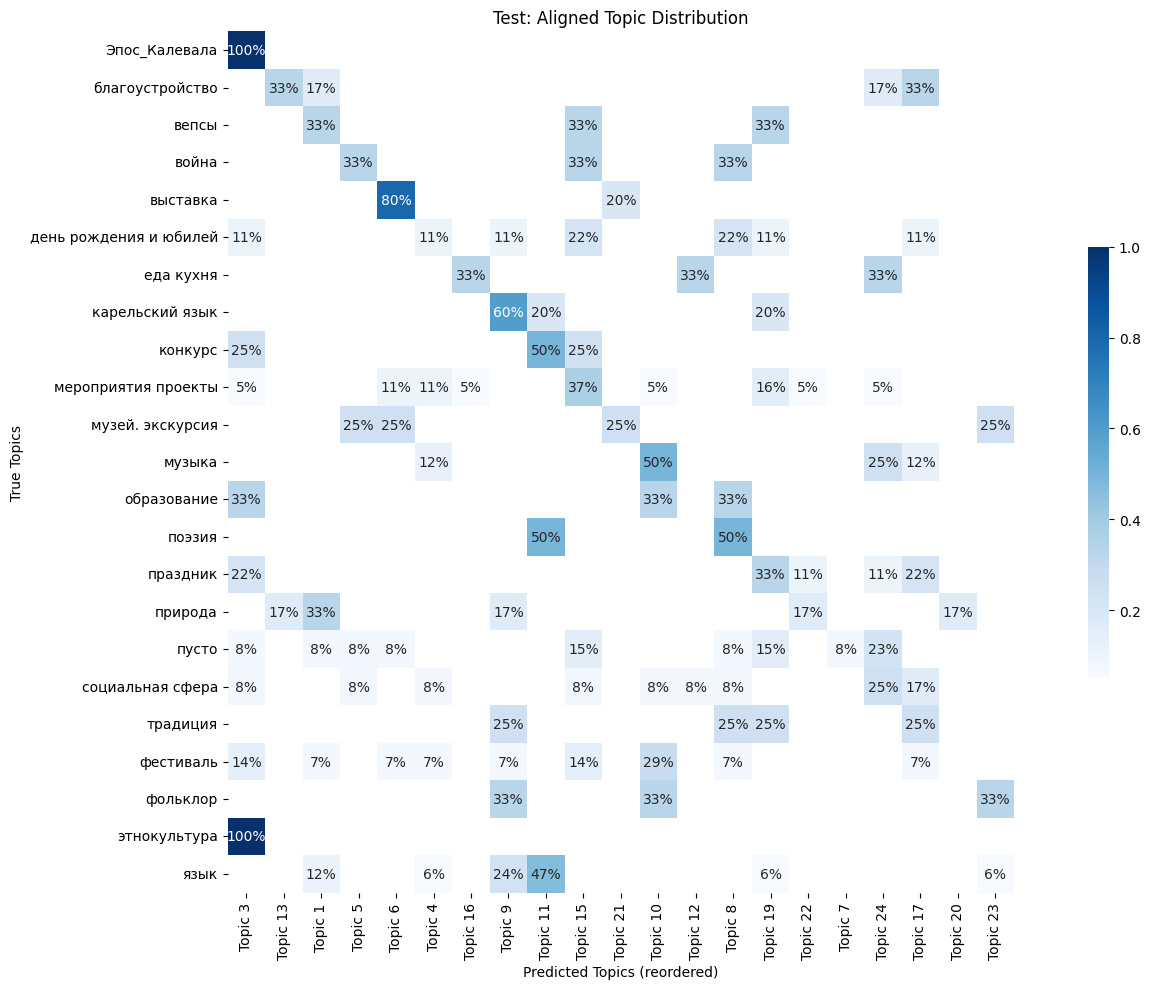

In [ ]:
# Evaluation on the test set (second part of the file)

# Create DataFrames for predicted topic distributions (train and test)
train_eval = pd.DataFrame(data=lda.transform(doc_train_matrix),
                          columns=topic_labels,
                          index=train_docs.topic)

test_eval = pd.DataFrame(data=lda.transform(doc_test_matrix),
                         columns=topic_labels,
                         index=test_docs.topic)

# Predict topic with the highest probability for each test document
# Save it to a DataFrame together with the original text
test_assignments = (
    test_eval.idxmax(axis=1)  # Predicted topic (with highest probability)
    .to_frame(name='predicted')
    .reset_index()            # Restore true topic as a column
)
test_assignments['text'] = test_docs.text.values

# Compute confusion matrix: how predicted topics match true topics
conf_matrix = test_assignments.groupby(['topic', 'predicted']).size().unstack(fill_value=0)
conf_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)  # Normalize by rows

# Reorder predicted topics to better match true ones
from scipy.optimize import linear_sum_assignment
import numpy as np

try:
    row_ind, col_ind = linear_sum_assignment(-conf_matrix.values)
    ordered_predicted = conf_matrix.columns[col_ind[np.argsort(row_ind)]]

    # Create a mask for zero values (True means "mask this cell")
    mask = conf_matrix.loc[conf_matrix.index, ordered_predicted] == 0

    plt.figure(figsize=(15, 10))
    sns.heatmap(
        conf_matrix.loc[conf_matrix.index, ordered_predicted],
        annot=True,
        fmt='.0%',         # Display as '0%' (no decimal)
        cmap='Blues',
        square=True,
        mask=mask,         # Mask cells with zero value
        cbar_kws={"shrink": 0.5}
    )
    plt.title('Test: Aligned Topic Distribution')
    plt.ylabel('True Topics')
    plt.xlabel('Predicted Topics (reordered)')
    plt.tight_layout()

except ValueError as e:
    print(f"Error while building heatmap: {e}")
    print(conf_matrix)

# Compute classification accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_assignments['topic'], test_assignments['predicted'])
print(f"Accuracy on the test set: {accuracy:.2%}")

# Save predictions for the topic 'война'
war_assignments = test_assignments[test_assignments['topic'] == 'война']
war_assignments.to_csv("war.csv", index=False)

# Save all predictions
test_assignments.to_csv("res.csv", index=False)